# Exercícios

1. A partir de um tempo inicial t escolhido por você, diminua o volume de um áudio em 10% (fixos) por segundo.
    * O decrescimento deve parar quando o volume atingir 0%, e em seguida o trecho de áudio que sofreu a diminuição deve ser:
    * Salvo com taxa de amostragem inalterada;
    * Tocado, 50% mais grave com relação à taxa de amostragem original nos primeiros 5 segundos e 50% mais agudo com relação à taxa de amostragem original nos segundos restantes;


* t + 0 até t + 1: volume = 90% nesse trecho de 1 segundo;
* t + 1 até t + 2: volume = 80% nesse trecho de 1 segundo;
* t + 2 até t + 3: volume = 70% nesse trecho de 1 segundo;
* t + 3 até t + 4: volume = 60% nesse trecho de 1 segundo;
* E assim por diante...
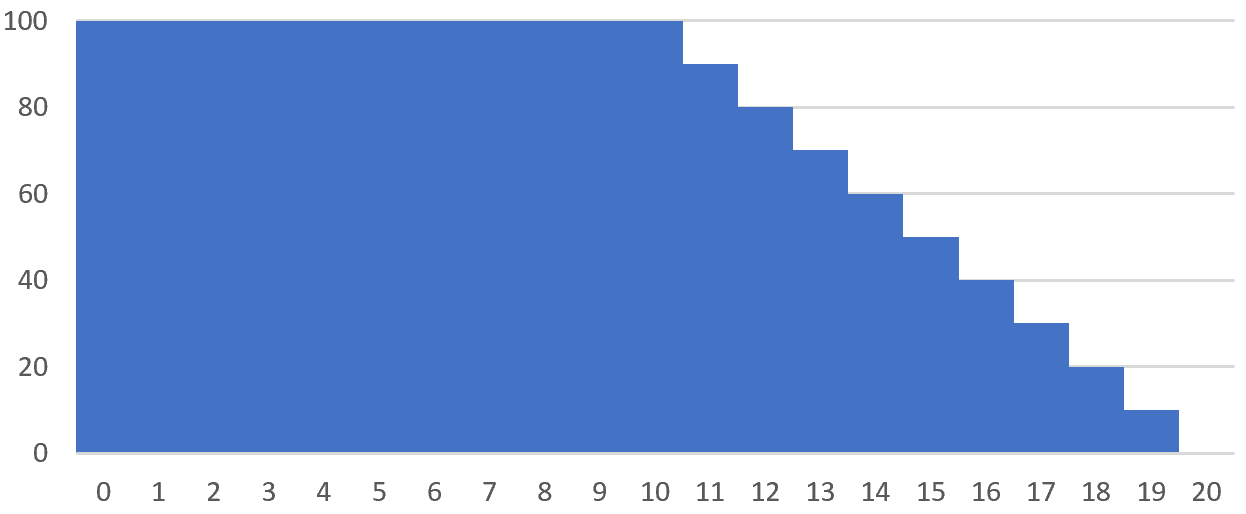
Com t = 10.

In [21]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd

# Função para modificar a taxa de amostragem
def change_sample_rate(data, original_rate, new_rate):
    if data.shape[0] == 0:
        return data
    duration = data.shape[0] / original_rate
    new_length = int(duration * new_rate)
    new_data = np.zeros((new_length, data.shape[1]), dtype=data.dtype)
    for c in range(data.shape[1]):
        new_data[:, c] = np.interp(
            np.linspace(0, 1, new_length),
            np.linspace(0, 1, data.shape[0]),
            data[:, c]
        )
    return new_data

# Carregar o arquivo de áudio
input_file = 'Roundabout.wav'
output_file = 'saida_arquivo.wav'
samplerate, data = wavfile.read(input_file)

# Verificar se o áudio é estéreo ou mono
if len(data.shape) > 1:
    channels = data.shape[1]
else:
    channels = 1
    data = data[:, np.newaxis]

# Tempo inicial em segundos
t = 10

# Converter tempo inicial para amostras
start_sample = int(t * samplerate)

# Verificar se o tempo inicial está dentro do comprimento do áudio
max_t = len(data) / samplerate
if t >= max_t:
    raise ValueError(f"O tempo inicial t ({t} segundos) está além do comprimento do áudio ({max_t:.2f} segundos).")

# Reduzir o volume conforme os segmentos especificados
for i in range(10):
    start_idx = start_sample + i * samplerate
    end_idx = start_sample + (i + 1) * samplerate
    if start_idx >= len(data):
        break
    duration = end_idx - start_idx
    factor = 1 - (i + 1) * 0.1
    if factor < 0:
        factor = 0
    data[start_idx:end_idx] = (data[start_idx:end_idx].astype(np.float64) * factor).astype(np.int16)

# Separar os primeiros 5 segundos para tornar 50% mais grave
end_grave = start_sample + 5 * samplerate
data_grave = data[start_sample:end_grave]
data_grave_resampled = change_sample_rate(data_grave, samplerate, int(samplerate * 1.5))

# Separar os segundos restantes para tornar 50% mais agudo
data_agudo = data[end_grave:]
data_agudo_resampled = change_sample_rate(data_agudo, samplerate, int(samplerate * 0.5))

# Concatenar os dois trechos
output_data = np.concatenate((data[:start_sample], data_grave_resampled, data_agudo_resampled))

# Remover o canal extra se o áudio original for mono
if channels == 1:
    output_data = output_data[:, 0]

# Tocar o áudio modificado
sd.play(output_data, samplerate)
sd.wait()

# Salvar o novo arquivo de áudio
wavfile.write(output_file, samplerate, output_data.astype(np.int16))
